In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/g-research-crypto-forecasting/example_sample_submission.csv
/kaggle/input/g-research-crypto-forecasting/asset_details.csv
/kaggle/input/g-research-crypto-forecasting/example_test.csv
/kaggle/input/g-research-crypto-forecasting/train.csv
/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/__init__.py


In [2]:
import gresearch_crypto
env = gresearch_crypto.make_env()
iter_test = env.iter_test()
df = pd.read_csv('/kaggle/input/g-research-crypto-forecasting/train.csv', 
                 usecols=['Target', 'Asset_ID','timestamp'], dtype={'Asset_ID': 'int8'})
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.set_index('datetime').drop('timestamp', axis=1)

In [3]:
df.shape

(24236806, 2)

In [4]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10


In [5]:
df_21_6 = df[(df.index.year == 2021) & (df.index.month > 5)]
print(df_21_6.shape)

(2256987, 2)


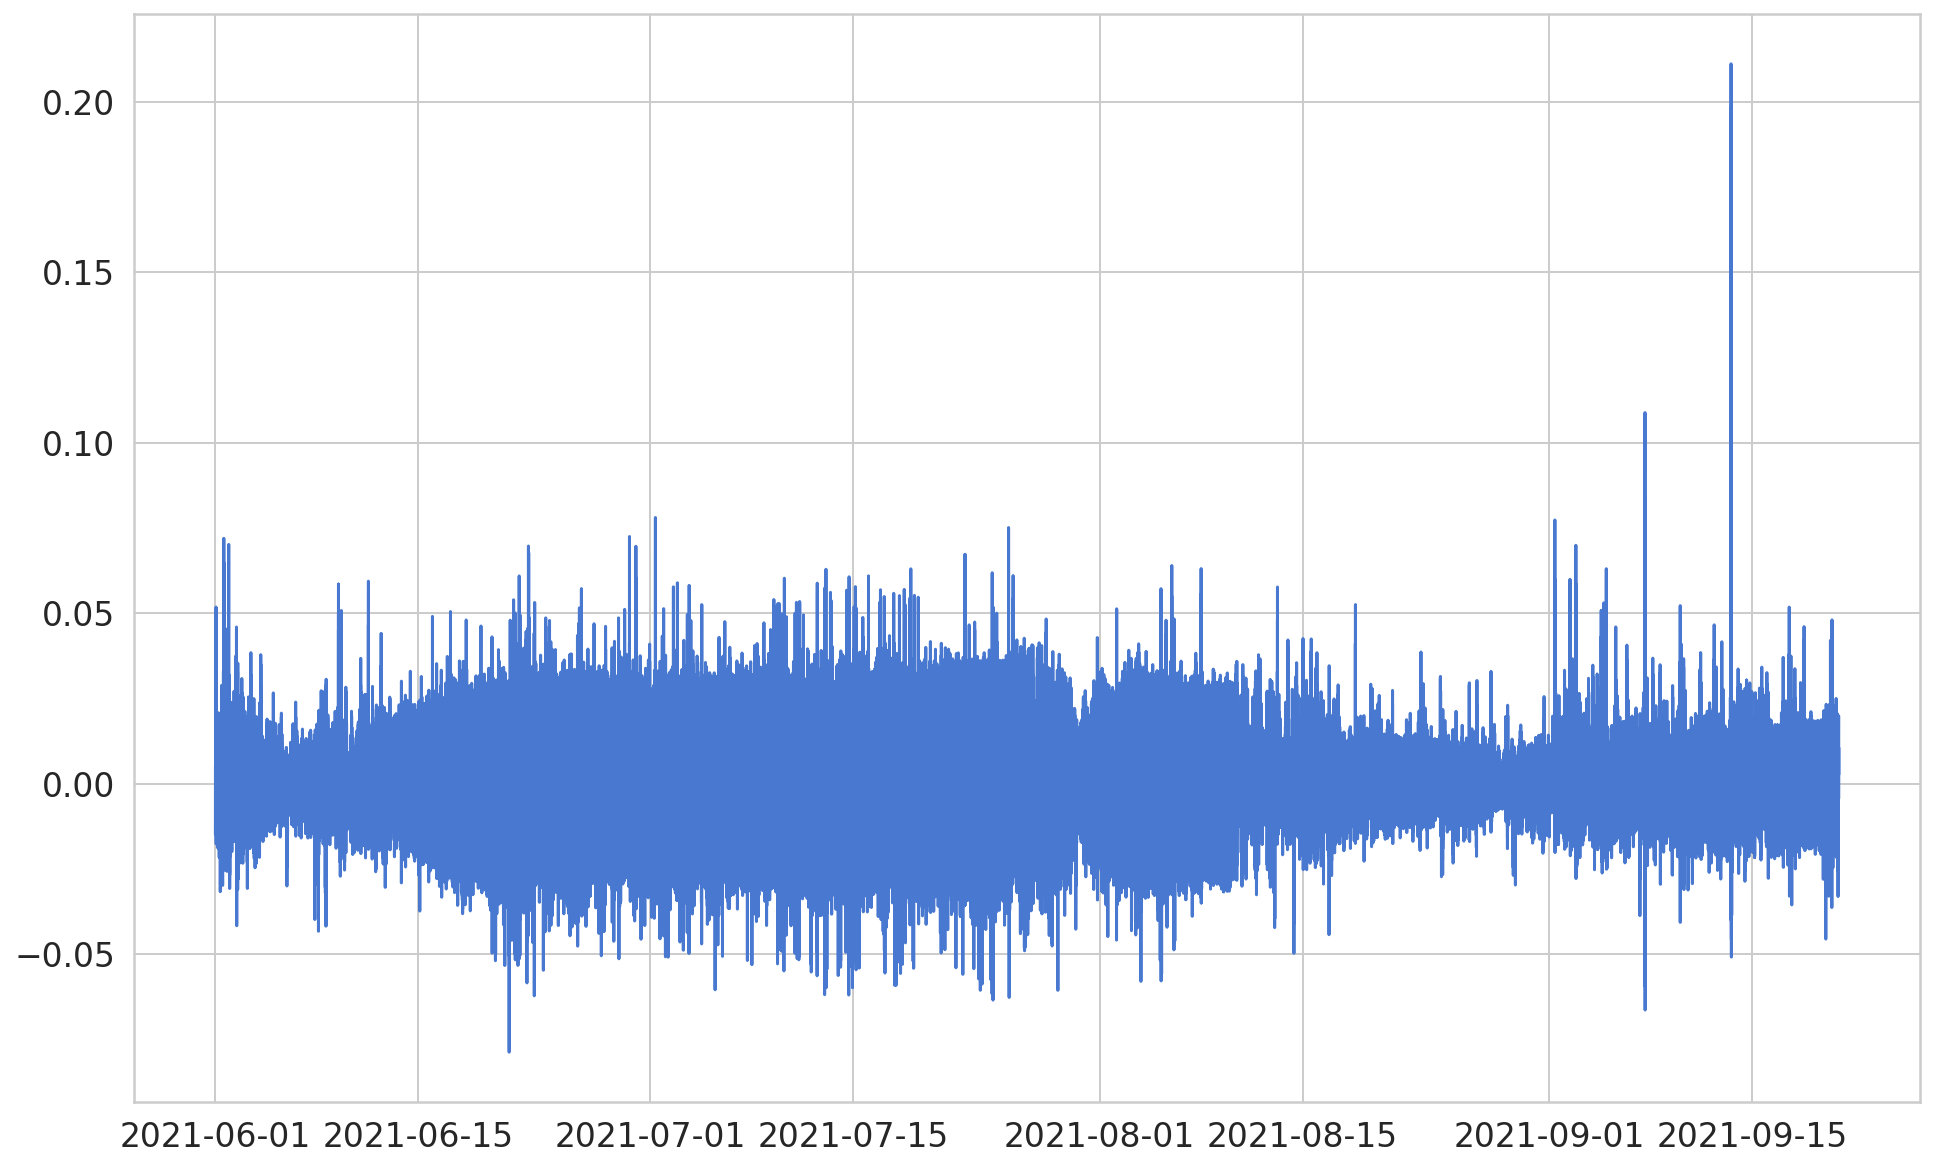

In [6]:
plt.plot(df_21_6.index, df_21_6.Target)
plt.show()

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
bitcoin = df_21_6.loc[df_21_6.Asset_ID == 1]
bitcoin.drop("Asset_ID", axis=1, inplace=True)
print(bitcoin.shape)
df_mean = round(bitcoin.Target.dropna().mean(), 5)
bitcoin.Target.fillna(df_mean, inplace=True)

(161277, 1)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


### Train on Aug up to Sept
### Test on Sept

In [9]:
btc_train = bitcoin[(bitcoin.index.month >= 8) & (bitcoin.index.month < 9)]
print(btc_train.shape)
btc_test = bitcoin[(bitcoin.index.month >= 9)]
print(btc_test.shape)

(44639, 1)
(28800, 1)


In [10]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [11]:
time_steps = 10
X_train, y_train = create_dataset(btc_train, btc_train.Target, time_steps)
X_test, y_test = create_dataset(btc_test, btc_test.Target, time_steps)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(44629, 10, 1) (44629,) (28790, 10, 1) (28790,)


In [12]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(units=1))
model.compile( loss="mean_squared_error", 
             optimizer= keras.optimizers.Adam(0.001))

2021-12-28 04:25:21.722252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 04:25:21.815591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 04:25:21.816298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 04:25:21.817469: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
history = model.fit(X_train, y_train, epochs=30, batch_size=100, validation_split=0.1, verbose=1, shuffle=False)

2021-12-28 04:25:24.418642: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-12-28 04:25:26.485666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


402/402 [==============================] - 5s 5ms/step - loss: 2.6601e-06 - val_loss: 2.6194e-07
Epoch 2/30
402/402 [==============================] - 1s 3ms/step - loss: 5.5857e-07 - val_loss: 2.1264e-07
Epoch 3/30
402/402 [==============================] - 1s 3ms/step - loss: 4.5566e-07 - val_loss: 1.8100e-07
Epoch 4/30
402/402 [==============================] - 1s 3ms/step - loss: 4.1774e-07 - val_loss: 1.7216e-07
Epoch 5/30
402/402 [==============================] - 1s 3ms/step - loss: 4.0297e-07 - val_loss: 1.7252e-07
Epoch 6/30
402/402 [==============================] - 1s 3ms/step - loss: 3.9819e-07 - val_loss: 1.8747e-07
Epoch 7/30
402/402 [==============================] - 1s 3ms/step - loss: 3.9879e-07 - val_loss: 1.7112e-07
Epoch 8/30
402/402 [==============================] - 2s 4ms/step - loss: 3.9867e-07 - val_loss: 1.6104e-07
Epoch 9/30
402/402 [==============================] - 2s 4ms/step - loss: 3.9833e-07 - val_loss: 1.5928e-07
Epoch 10/30
402/402 [==================

In [14]:
y_pred = model.predict(X_test)

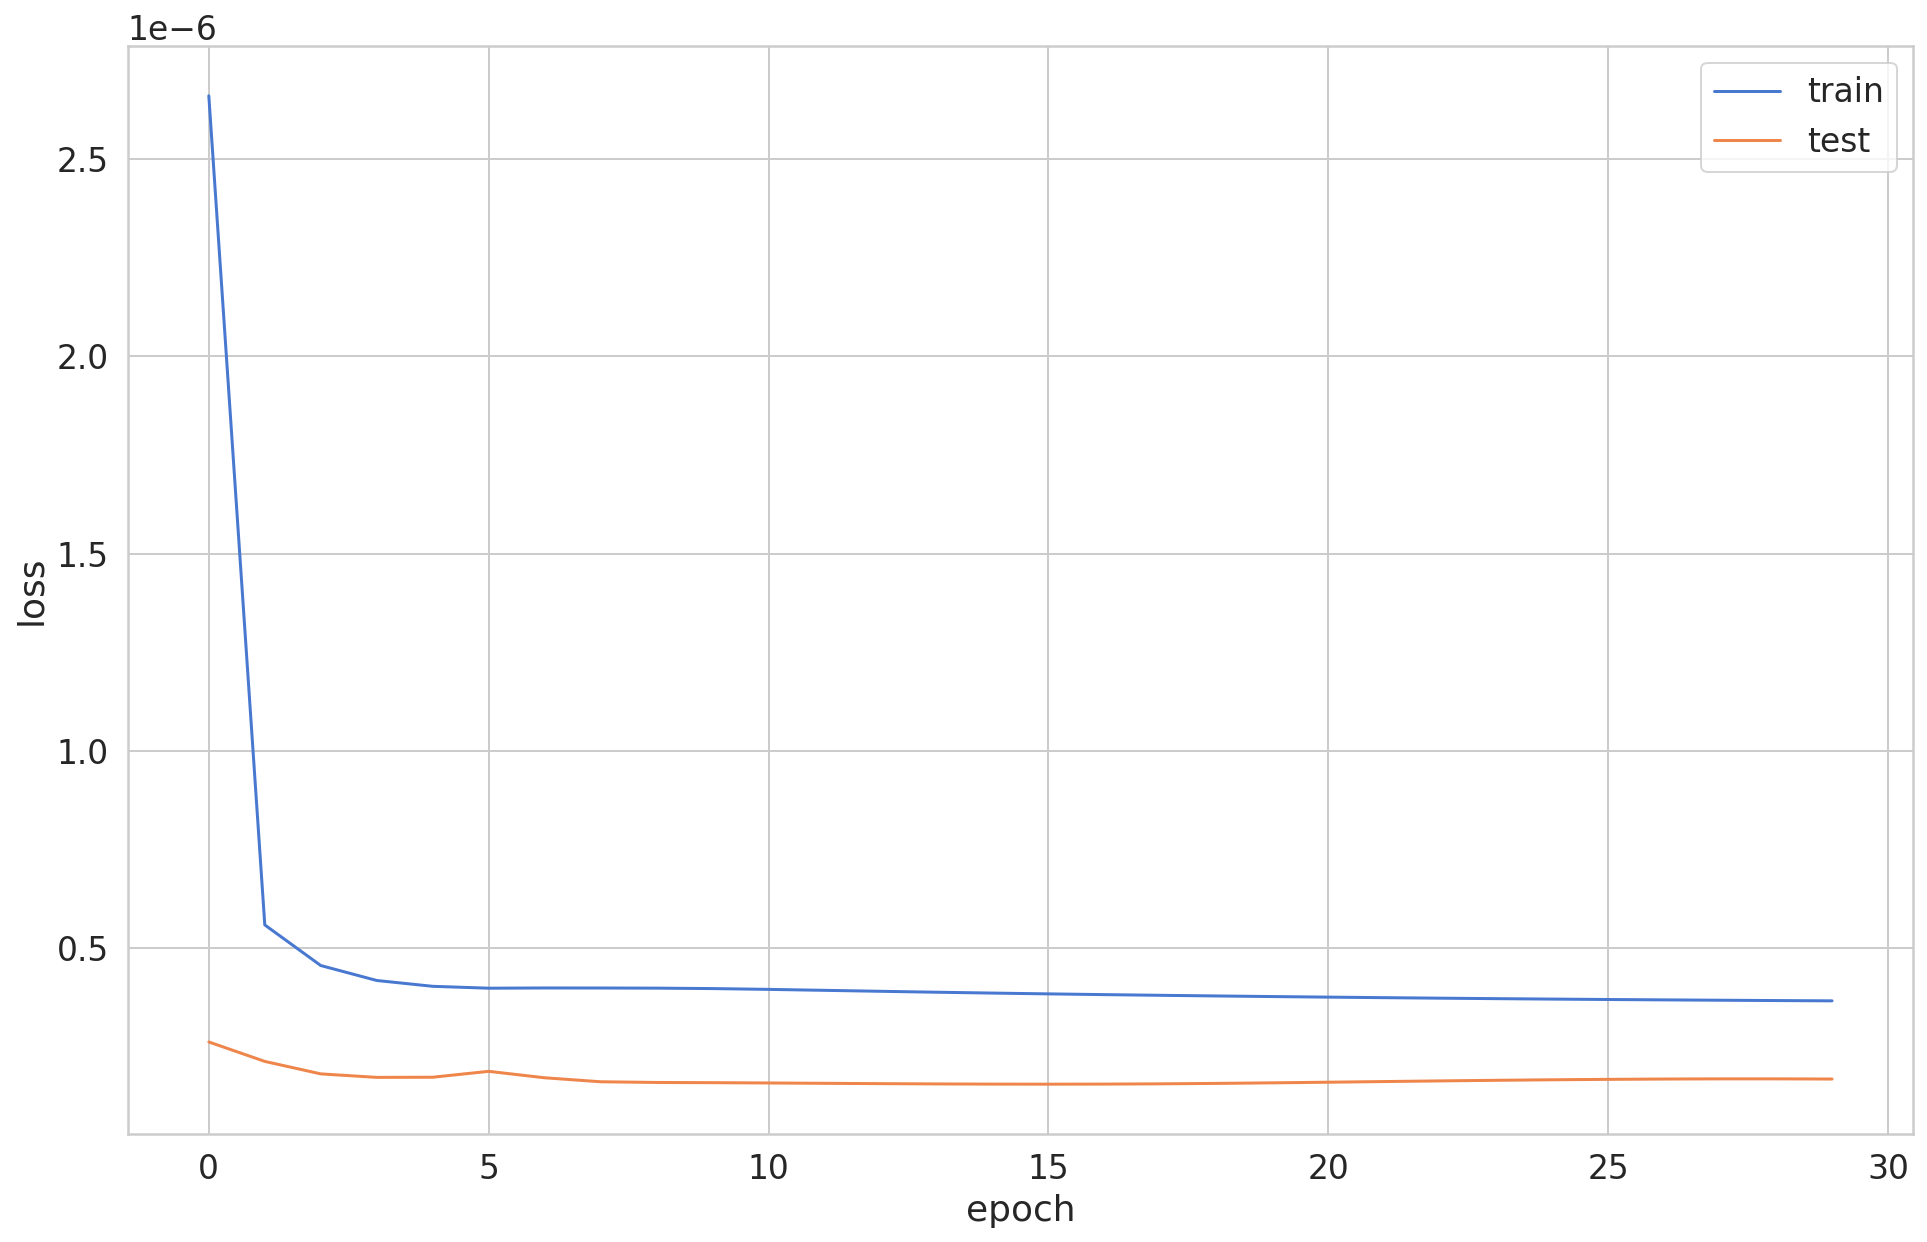

In [15]:
plt.plot(history.epoch,history.history.get('loss'),label='train')
plt.plot(history.epoch,history.history.get('val_loss'),label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

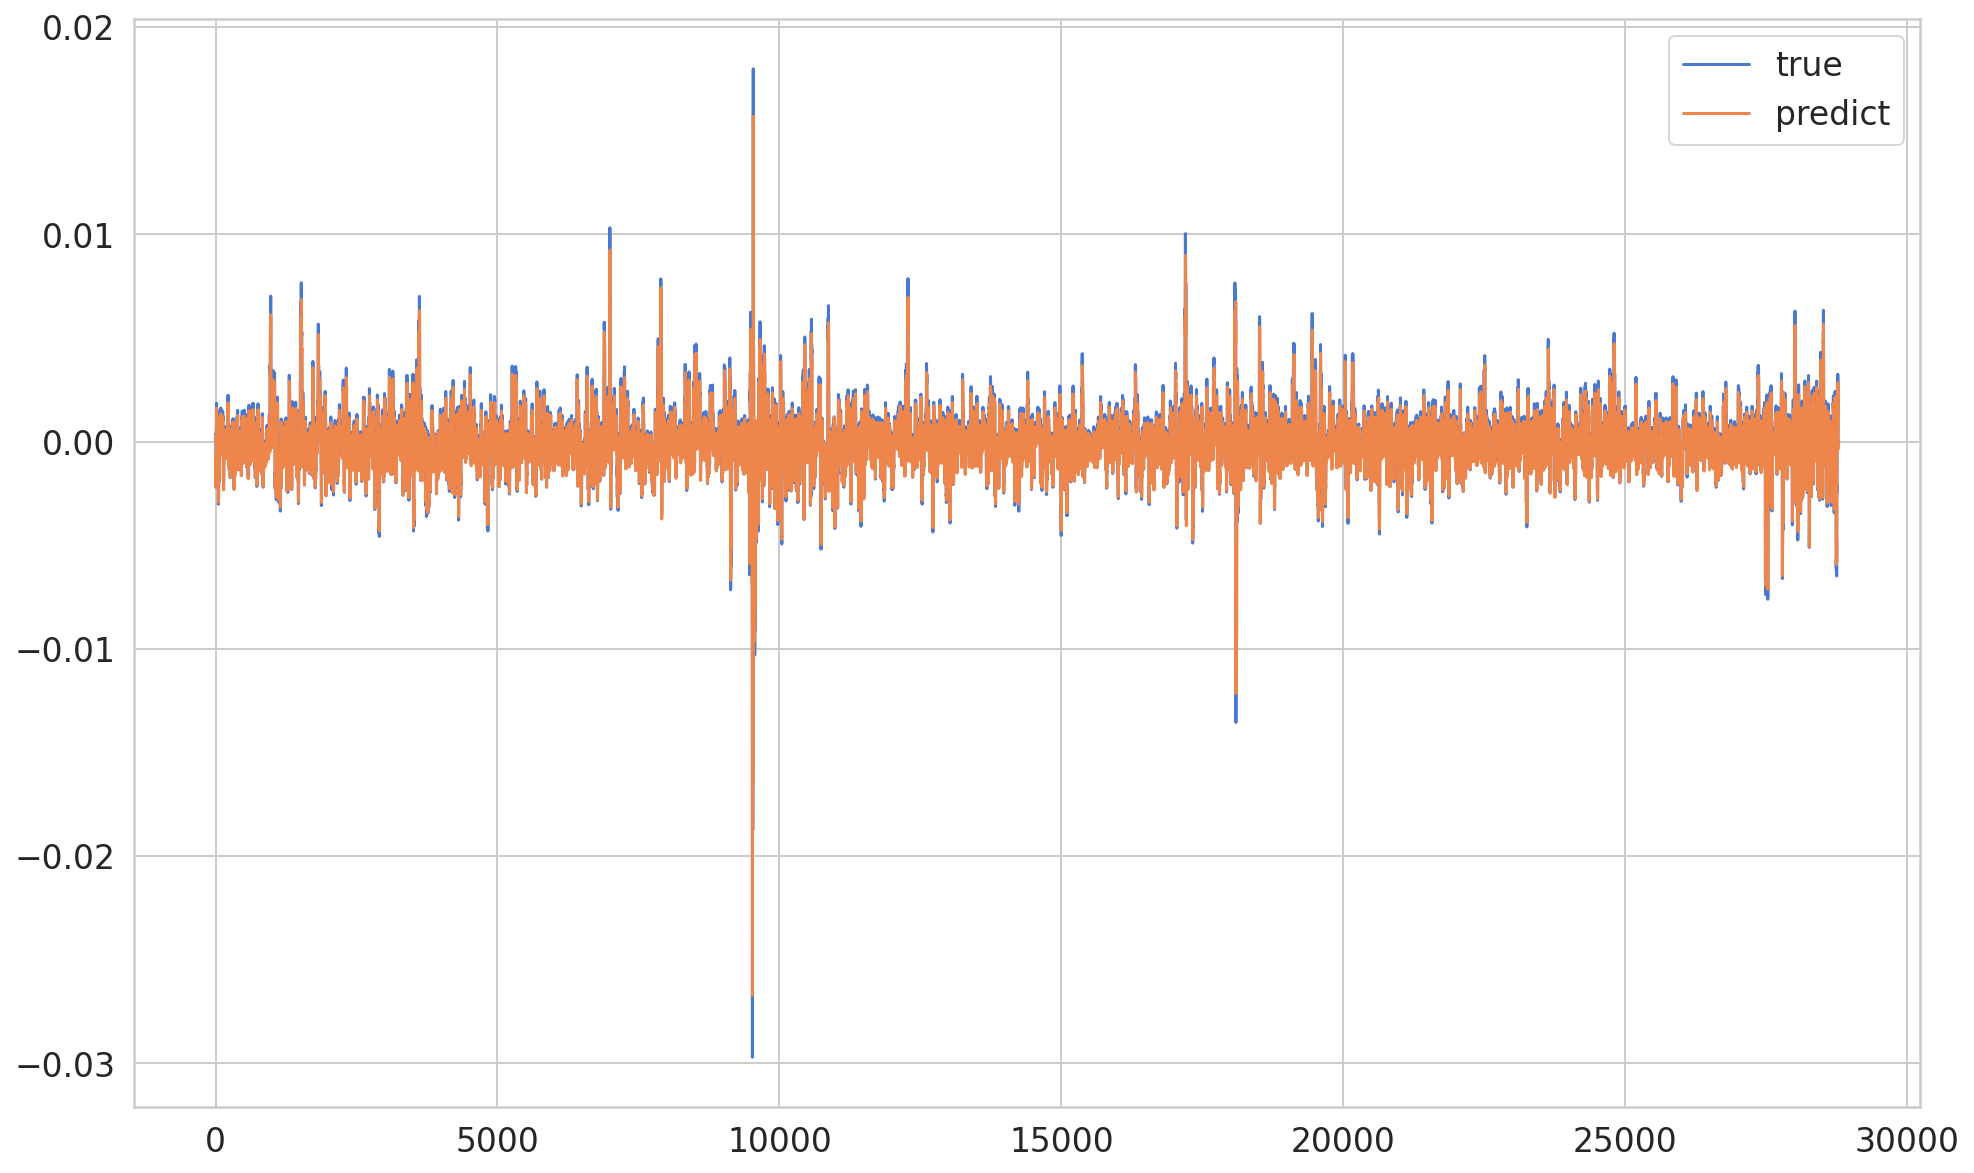

In [16]:
plt.plot(y_test,label='true')
plt.plot(y_pred,label='predict')
plt.legend()
plt.show()

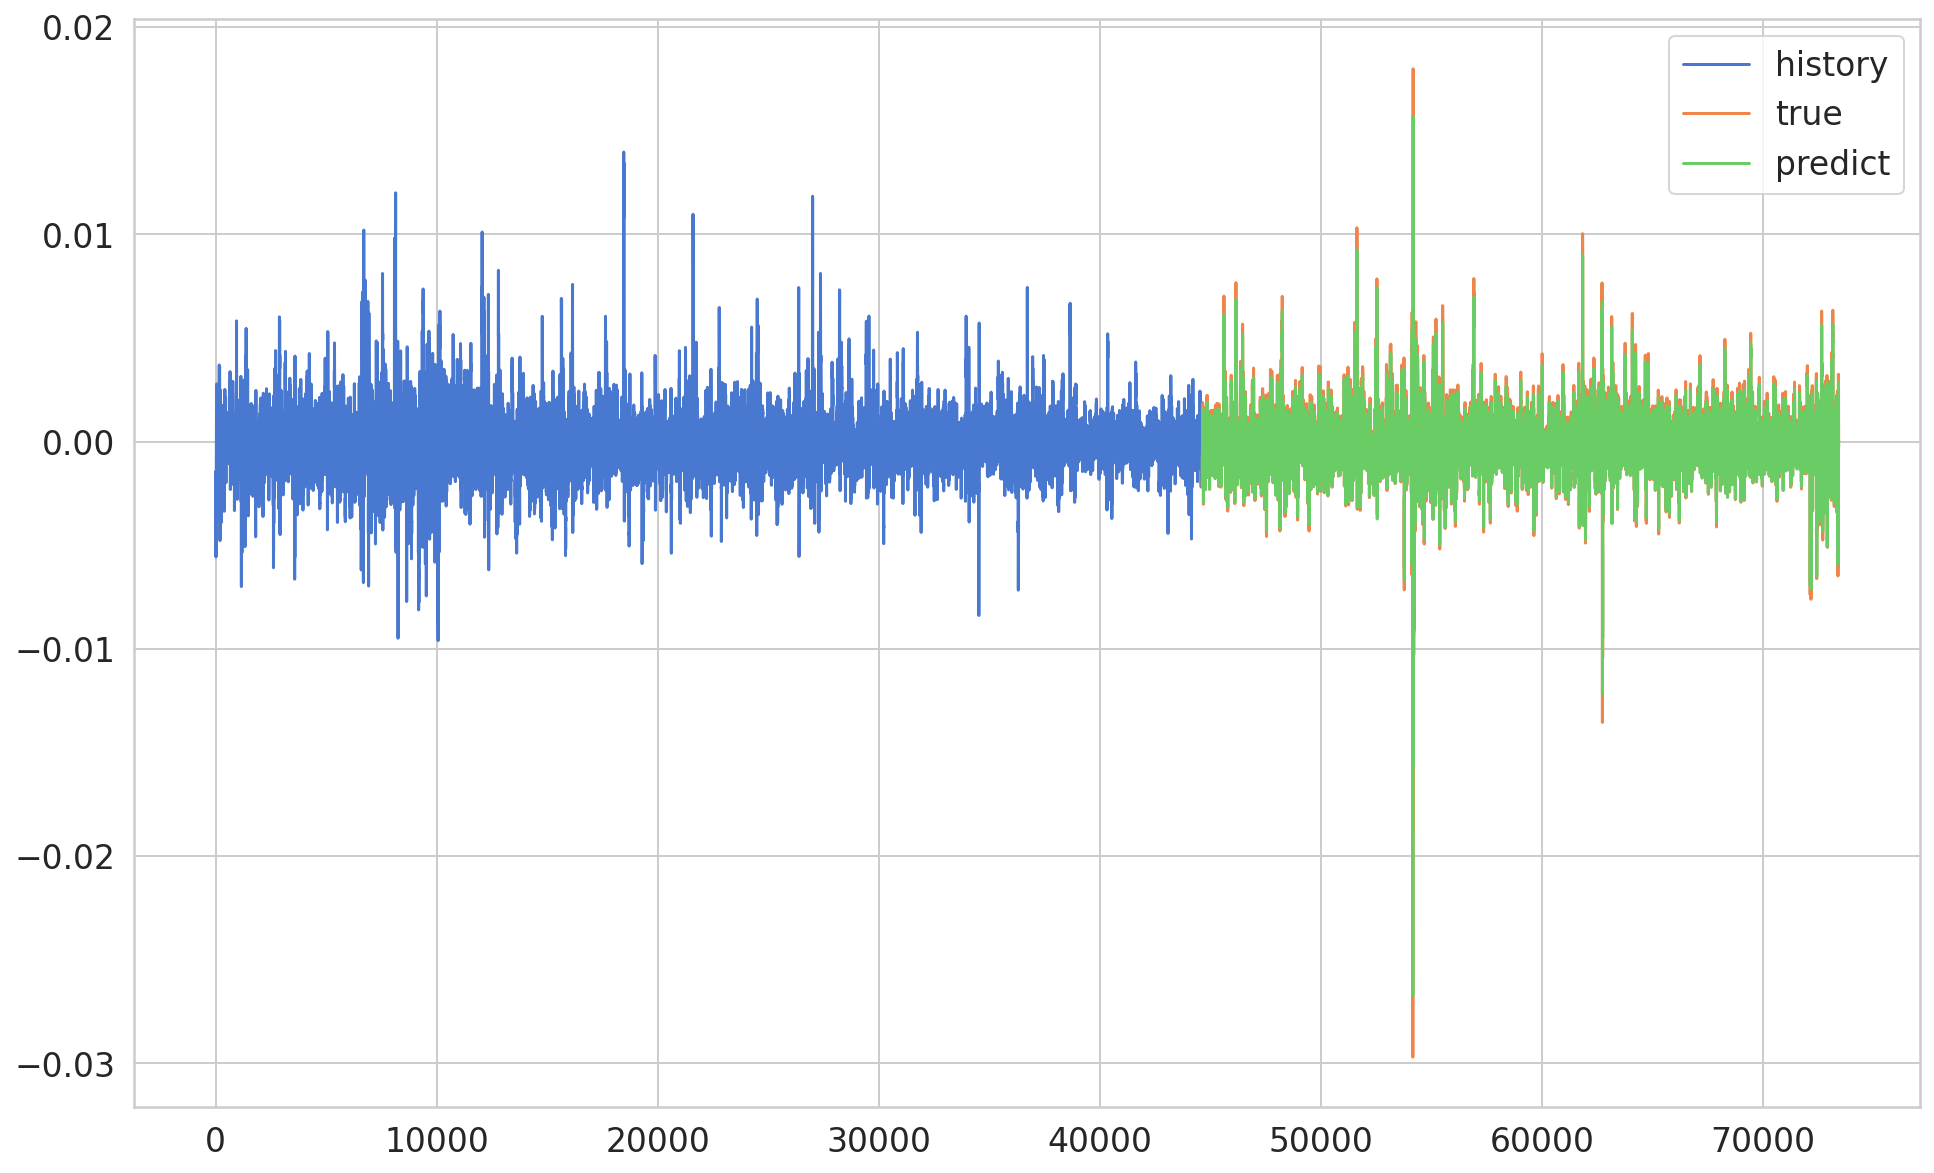

In [17]:
plt.plot(range(0,len(y_train)),y_train,label='history')
plt.plot(range(len(y_train),len(y_train)+len(y_test)),y_test,label='true')
plt.plot(range(len(y_train),len(y_train)+len(y_pred)),y_pred,label='predict')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
r2_score(y_test.reshape(-1,1), y_pred)

0.8451014906308292

In [19]:
mean_squared_error(y_test, y_pred)

2.918769889726127e-07